In [1]:
import numpy as np
import pandas as pd

In [6]:
import os
for dirname, _, filenames in os.walk('archive/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

archive/input_data.npz


In [10]:
import numpy as np

npz = np.load('archive/input_data.npz')

X_train = npz['X_train']
Y_train = npz['Y_train']
del npz

print('We have {} examples to work with'.format(Y_train.shape[0]))

We have 4113 examples to work with


In [12]:
X_train.shape, Y_train.shape

((4113, 75, 75, 3), (4113,))

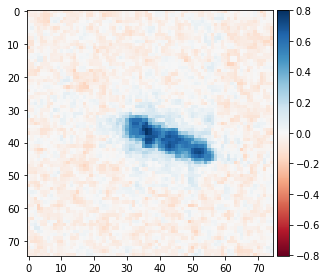

This is: Ship


In [29]:
from skimage.io import imshow
import matplotlib.pyplot as plt

ix = 100 #0-4112
imshow(np.squeeze(X_train[ix,:,:,2]))#Looking at the combined channel
plt.show()
labels = ['Ship','Iceberg']  #0 is no iceberg(ship) and 1 is iceberg
print ('This is:',labels[int(Y_train[ix])])

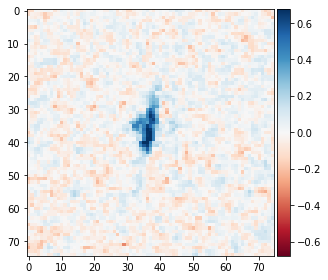

This is: Iceberg


In [30]:
ix = 110 #0-4112
imshow(np.squeeze(X_train[ix,:,:,2]))#Looking at the combined channel
plt.show()
labels = ['Ship','Iceberg']  #0 is no iceberg(ship) and 1 is iceberg
print ('This is:',labels[int(Y_train[ix])])

In [36]:
from tensorflow.keras.layers import Input

# We have 2 inputs, 1 for each picture
left_input = Input((75,75,3))
right_input = Input((75,75,3))

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Conv2D, Flatten, Dense

# We will use 2 instances of 1 network for this task
base_network = Sequential([
    Conv2D(5,3, input_shape=(75,75,3)),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(5,3),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    Flatten(),
    Dense(18),
    Activation('sigmoid')
])

In [39]:
processed_a = base_network(left_input)
processed_b = base_network(right_input)

In [40]:
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

# Getting the L1 Distance between the 2 encodings
L1_layer = Lambda(lambda tensor:K.abs(tensor[0] - tensor[1]))

# Add the distance function to the network
L1_distance = L1_layer([processed_a, processed_b])

In [42]:
from tensorflow.keras.models import Model

prediction = Dense(1,activation='sigmoid')(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

In [44]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(0.001, decay=2.5e-4)

siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

In [45]:
siamese_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 18)           6912        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 18)           0           sequential[2][0]             

In [46]:
import random

# First let's separate the dataset from 1 matrix to a list of matricies
image_list = np.split(X_train[:1000],1000)
label_list = np.split(Y_train[:1000],1000)

left_input = []
right_input = []
targets = []

#Number of pairs per image
pairs = 5
#Let's create the new dataset to train on
for i in range(len(label_list)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i: #Make sure it's not comparing to itself
            compare_to = random.randint(0,999)
        left_input.append(image_list[i])
        right_input.append(image_list[compare_to])
        if label_list[i] == label_list[compare_to]:# They are the same
            targets.append(1.)
        else:# Not the same
            targets.append(0.)
            
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))

iceimage = X_train[101]
test_left = []
test_right = []
test_targets = []

for i in range(Y_train.shape[0]-1000):
    test_left.append(iceimage)
    test_right.append(X_train[i+1000])
    test_targets.append(Y_train[i+1000])

test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets))

In [47]:
siamese_net.fit([left_input,right_input], targets,
          batch_size=16,
          epochs=10,
          verbose=1,
          validation_data=([test_left,test_right],test_targets))

Epoch 1/10
313/313 [==============================] - 24s 15ms/step - loss: 0.6933 - accuracy: 0.5014 - val_loss: 0.6934 - val_accuracy: 0.5300
Epoch 2/10
313/313 [==============================] - 4s 13ms/step - loss: 0.6809 - accuracy: 0.5788 - val_loss: 0.6973 - val_accuracy: 0.5024
Epoch 3/10
313/313 [==============================] - 4s 12ms/step - loss: 0.5746 - accuracy: 0.7256 - val_loss: 0.4946 - val_accuracy: 0.8063
Epoch 4/10
313/313 [==============================] - 4s 13ms/step - loss: 0.4833 - accuracy: 0.7904 - val_loss: 0.4888 - val_accuracy: 0.8214
Epoch 5/10
313/313 [==============================] - 4s 13ms/step - loss: 0.4414 - accuracy: 0.8192 - val_loss: 0.5029 - val_accuracy: 0.8153
Epoch 6/10
313/313 [==============================] - 4s 13ms/step - loss: 0.4148 - accuracy: 0.8356 - val_loss: 0.5268 - val_accuracy: 0.7976
Epoch 7/10
313/313 [==============================] - 4s 13ms/step - loss: 0.3910 - accuracy: 0.8450 - val_loss: 0.4626 - val_accuracy: 0.818

In [48]:
predictions = siamese_net.predict([test_left, test_right])

In [49]:
predictions

array([[0.86751956],
       [0.18107088],
       [0.7888424 ],
       ...,
       [0.23339494],
       [0.91250634],
       [0.09332917]], dtype=float32)

In [50]:
def predict(num):
    i#mshow(np.squeeze(right_input[num,:,:,2]))#Looking at the combined channel
    imshow(np.squeeze(test_left[num,:,:,2]))
    plt.show()
    labels = ['Ship','Iceberg']  #0 : ship; 1: iceberg 
    print ('This is:',labels[int(test_targets[num])])
    print('Siamese network predicts: ' + labels[round(float(predictions[num]))])

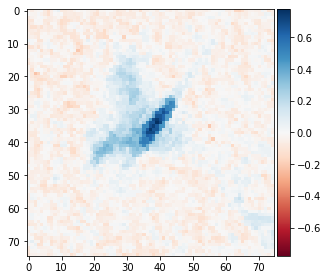

This is: Iceberg
Siamese network predicts: Iceberg


In [55]:
predict(101)